有很多采样技术。代理建模中最常用的方法之一称为拉丁超立方体采样 （LHS），它旨在从随机技术和更结构化的方法（如统一采样）中获得最大收益。执行 LHS 采样的代码非常简单，但需要一个名为 “smt” 的库. 您可以像这样安装它：

Text(0, 0.5, '$y_1$')

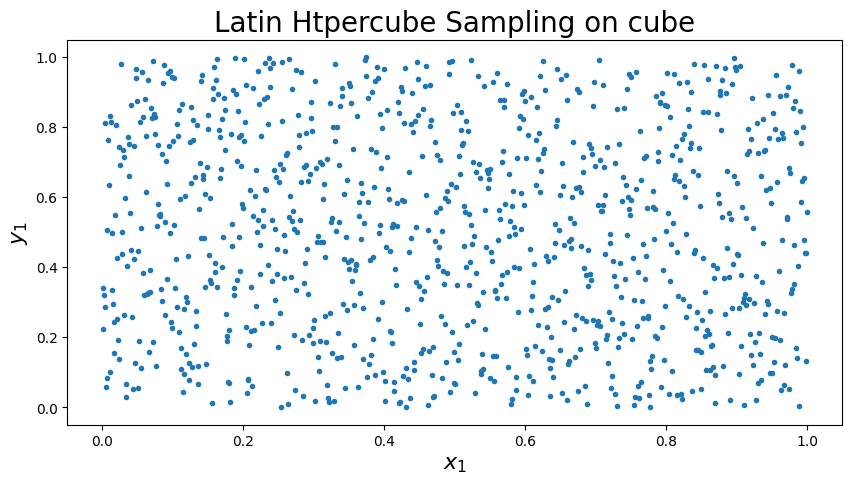

In [1]:
from smt.sampling_methods import LHS 
import numpy as np 
import matplotlib.pyplot as plt 
xlimits_cube = np.array([[0.0,1.0],[0.0,1.0],[0.0,1.0]]) 
latin_hypercube_sample = LHS(xlimits=xlimits_cube) 
num = 1000 
latin_hypercube_sample = latin_hypercube_sample(num) 
plt.figure(figsize=(10,5)) 
plt.title("Latin Htpercube Sampling on cube",fontsize=20) 
plt.plot(latin_hypercube_sample[:, 0],latin_hypercube_sample[:, 1],'.') 
plt.xlabel(r'$x_1$',fontsize=16) 
plt.ylabel(r'$y_1$',fontsize=16)

代理模型选择和训练
在你对原始参数空间进行采样后，我们可以使用相同的 smt 库来训练机器学习模型。请记住，您通常只有有限数量的积分，因此您可能希望尝试使用非常简单的模型而不是像神经网络这样超级复杂的算法来解决问题。

例如，径向基函数 （RBF） 是一个相当简单的模型，即使作为数据集的点很少，它也具有良好的性能。RBF 模型通过组合以每个数据点为中心的加权径向函数来预测结果，通常使用高斯函数。这种方法非常有效，因为它可以捕获数据中的局部变化，并且即使数据集很小，也可以提供平滑的插值。

我用了很多大词，但事实是，一切都可以用极几行代码实现：

___________________________________________________________________________
   
                                    RBF
___________________________________________________________________________
   
 Problem size
   
      # training points.        : 8
   
___________________________________________________________________________
   
 Training
   
   Training ...
      Initializing linear solver ...
         Performing LU fact. (8 x 8 mtx) ...
         Performing LU fact. (8 x 8 mtx) - done. Time (sec):  0.0000000
      Initializing linear solver - done. Time (sec):  0.0000000
      Solving linear system (col. 0) ...
         Back solving (8 x 8 mtx) ...
         Back solving (8 x 8 mtx) - done. Time (sec):  0.0000000
      Solving linear system (col. 0) - done. Time (sec):  0.0000000
   Training - done. Time (sec):  0.0009992
___________________________________________________________________________
   
 Evaluation
   
      # eval points. : 1000
   
   Predicting ...
   Predicting

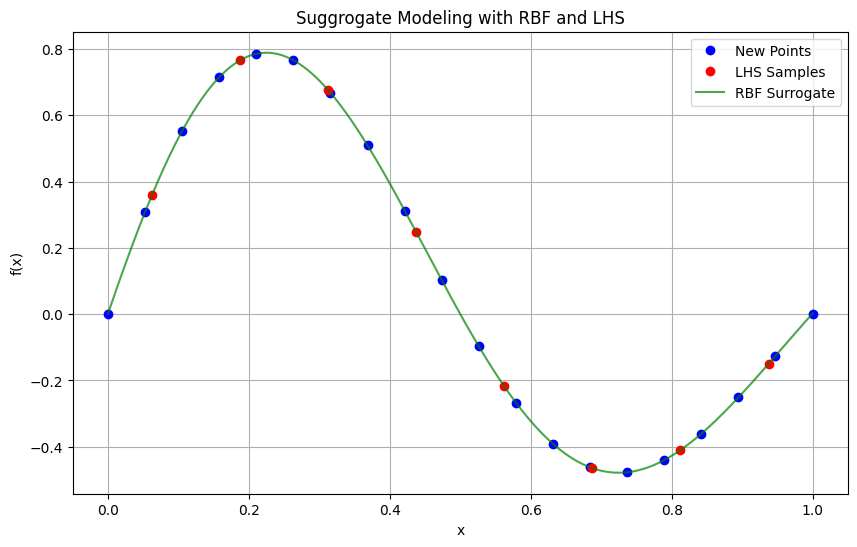

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from smt.sampling_methods import LHS
from smt.surrogate_models import RBF

def true_function(x):
    return np.sin(2 * np.pi * x) * np.exp(-x) 

n_samples = 8 
x_limits = np.array([[0.0,1.0]]) 
sampling = LHS(xlimits=x_limits) 
x_train = sampling(n_samples) 

y_train = true_function(x_train) 

surrogate = RBF() 
surrogate.set_training_values(x_train,y_train) 
surrogate.train() 

x_test = np.linspace(0, 1, 1000).reshape(-1,1) 
y_pred = surrogate.predict_values(x_test) 
plt.figure(figsize=(10,6)) 
x_new_points = np.linspace(0, 1, 20).reshape(-1,1) 
plt.plot(x_new_points,true_function(x_new_points),'o',label='New Points',color='blue') 
plt.plot(x_train,y_train,'o',label='LHS Samples',color='red') 
plt.plot(x_test,y_pred,label='RBF Surrogate',color='green',alpha=0.7) 
plt.legend() 
plt.xlabel('x') 
plt.ylabel('f(x)') 
plt.title('Suggrogate Modeling with RBF and LHS') 
plt.grid() 
plt.show()

质量评估
现在我们已经完成了 DoE 并训练了我们的代理模型，最后要做的是评估我们方法的质量。

给定一定的质量阈值（例如，小于 0.02 的均方误差），我们评估在测试集上，我们的代理模型是否小于或等于该值。如果答案是肯定的，那么我们就可以开始了。如果没有，我们必须对参数 space 进行重新采样。

我们通常有两种选择。例如，我们要么使用另一种 LHS 或其他“静态”方法进行重新采样，要么采用一些“自适应采样”策略。自适应抽样旨在对代理模型的误差（或不确定性）较大的区域进行抽样。重新采样阶段完成后，我们可以重新训练代理模型并再次评估质量。我们重复这两个步骤，直到我们收敛到所需的质量级别。

航空航天对代理模型的需求
在处理实际工程产品时，在早期概念设计期间做出的决策对预期的生命周期成本有很大影响。在我们之前看到的示例中，我们注意到，如果我们需要探索一个具有 10 个步骤的 3 维空间，那么我们需要的时间比探索 10 维空间所需的时间要少得多。

在 NASA 的特定案例中，给定车辆的一组参数，Advanced Concept Office （ACO） 的分析团队利用一组经过验证的工具来：

为客户提供整车质量明细
根据最坏情况的飞行载荷进行初步的结构尺寸调整（即升空重量的估计值）
执行轨迹优化以量化给定任务的集成飞行器性能
因此，使用 NASA 系统，对于一组给定的参数，我们得到了质量、结构尺寸和轨迹。尽管如此，这组参数非常耗时和资源：这就是代理建模的需要.